# Learning Distributed Word Representations and Sequence Predictions with Neural Networks




##Introduction
In this project we explore word embeddings and develop neural networks to learn about words.

We could try to match statistics about the words, or we could train a network that takes a sequence of words as input and learns to predict the word that comes next. In this project, we choose the latter.
        
We implement a linear embedding and then the backpropagation computations for a neural language model and then run some experiments to analyze the learned representation. We derive the updates mathematically, and then implement them using matrix and vector operations in NumPy.

## Setup

But first, some setup...

We upload *raw_sentences.txt* (available in the Github repo for this project).
This file contains the sentences that we will be using for this project. These sentences are fairly simple ones and cover a vocabulary of only 250 words.


In [ ]:
import collections
import pickle
import numpy as np
from tqdm import tqdm
import pylab
use_colab = True
if use_colab:
  from google.colab import drive

TINY = 1e-30
EPS = 1e-4
nax = np.newaxis

Now *data* is a Python dict which contains the vocabulary, as well as the inputs and targets for all three splits of the data. *data*['vocab'] is a list of the 250 words in the dictionary; *data*['vocab'][0] is the word with index 0, and so on. *data*['train_inputs'] is a 372,500 x 3 matrix where each row gives the indices of the 3 context words for one of the 372,500 training cases.
*data*['train_targets'] is a vector giving the index of the target word for each training case. The validation and test sets are handled analogously.

We have already extracted the 4-grams from this dataset and divided them into training, validation, and test sets. To inspect this data, we run the following:



We have already extracted the 4-grams from this dataset and divided them into training, validation, and test sets.
To inspect this data, we run the following:

In [ ]:
data = pickle.load(open('data.pk', 'rb'))
print(data['vocab'][0])
print(data['train_inputs'][:10])
print(data['train_targets'][:10])
print(data)

all
[[ 27  25  89]
 [183  43 248]
 [182  31  75]
 [116 246 200]
 [222 189 248]
 [ 41  73  25]
 [241  31 222]
 [222  31 157]
 [ 73  31 220]
 [ 41 191  90]]
[143 116 121 185   5  31  31 143  31  67]
{'vocab': ['all', 'set', 'just', 'show', 'being', 'money', 'over', 'both', 'years', 'four', 'through', 'during', 'go', 'still', 'children', 'before', 'police', 'office', 'million', 'also', 'less', 'had', ',', 'including', 'should', 'to', 'only', 'going', 'under', 'has', 'might', 'do', 'them', 'good', 'around', 'get', 'very', 'big', 'dr.', 'game', 'every', 'know', 'they', 'not', 'world', 'now', 'him', 'school', 'several', 'like', 'did', 'university', 'companies', 'these', 'she', 'team', 'found', 'where', 'right', 'says', 'people', 'house', 'national', 'some', 'back', 'see', 'street', 'are', 'year', 'home', 'best', 'out', 'even', 'what', 'said', 'for', 'federal', 'since', 'its', 'may', 'state', 'does', 'john', 'between', 'new', ';', 'three', 'public', '?', 'be', 'we', 'after', 'business', 'neve

In [ ]:
PARTIALLY_TRAINED_MODEL = 'partially_trained.pk'

# Part 1: GLoVE Word Representations

In this section we implement a simplified version of GLoVE [Jeffrey Pennington and
Manning]. Given a corpus with $V$ distinct words, we define the co-occurrence matrix $X ∈ V × V$
with entries $X_{ij}$ representing the frequency of the $i$-th word and $j$-th word in the corpus appearing in
the same *context* (in our case, the adjacent words). GLoVE aims to find a $d$-dimensional embedding
of the words that preserves properties of the co-occurrence matrix by representing the i-th word
with a $d$-dimensional vector $\mathbf{w}_i ∈ R^d$ and a scalar bias $\mathbf{b}_i ∈ R$. This objective can be written as
:  


<br>

<center>$$L(\{\mathbf{w}_i,b_i\}_{i=1}^V) = \sum_{i,j=1}^V (\mathbf{w}_i^\top\mathbf{w}_j + b_i + b_j - \log X_{ij})^2$$</center>

<br>

Note that when the bias terms are omitted, then GLoVE corresponds to finding a rank-$d$ symmetric factorization of the co-occurrence matrix.

<br>

Given a vocabulary size $V$ and embedding dimensionality $d$, the GLoVE model has $V ✕ (d+1)$ trainable parameters

<br>




We define a few functions for training the embedding:
*   `calculate_log_co_occurence` computes the log co-occurrence matrix of a given corpus
*   `train_GLoVE` runs momentum gradient descent to optimize the embedding
*   `loss_GLoVE`: Takes in as input the  $V\times d$ matrix $W$ (collection of $V$ embedding vectors, each d-dimensional); $V\times 1$ vector $\mathbf{b}$ (collection of $V$ bias terms); $V \times V$ log co-occurrence matrix. Outputs the loss of the GLoVE objective
*   `grad_GLoVE`: Takes in as input the $V\times d$ matrix $W$, $V\times 1$ vector $b$, and $V\times V$ log co-occurrence matrix. Outputs a $V\times d$ matrix grad_W containing the gradient of the loss function w.r.t. $W$; $V\times 1$ vector grad_b which is the gradient of the loss function with respect to $\mathbf{b}$.


We first implement `calculate_log_co_occurence` which computes the log co-occurrence matrix of a given corpus, and then run it on our training and validation datasets:

In [ ]:
vocab_size = 250

def calculate_log_co_occurence(word_data):
  "Compute the log-co-occurence matrix for our data."

  log_co_occurence = np.zeros((vocab_size, vocab_size))

  for input in word_data:
    log_co_occurence[input[0], input[1]] += 1
    log_co_occurence[input[1], input[2]] += 1

    # If we want symmetric co-occurence can also increment for these.
    log_co_occurence[input[1], input[0]] += 1
    log_co_occurence[input[2], input[1]] += 1

  delta_smoothing = 0.5  # A hyperparameter. 
  log_co_occurence += delta_smoothing  # Add delta so log doesn't break on 0's.
  log_co_occurence = np.log(log_co_occurence)
  
  return log_co_occurence


In [ ]:
log_co_occurence_train = calculate_log_co_occurence(data['train_inputs'])
log_co_occurence_valid = calculate_log_co_occurence(data['valid_inputs'])

Since we are interested in minimizing our objective function with respect to our parameters $\mathbf{W}$ and $\mathbf{b}$, we must first identify the gradient of the loss function with respect to these parameters.

The gradient of the loss function with respect to one parameter vector $\mathbf{w}_i$ is:

<center>$\frac{\delta L}{\delta w_{i}}=\sum_{j=1}^{V} 4\left(w_{i}^{T} w_{j}+b_{i}+b_{j}-\log X_{i j}\right) w_{j}$</center>

We now implement the functions for computing the gradient of the loss function with respect to the parameters $W$ and $\mathbf{b}$. We also define the training loop.

In [ ]:
def loss_GLoVE(W, b, log_co_occurence):
  "Compute the GLoVE loss."
  n,_ = log_co_occurence.shape
  return np.sum((W @ W.T + b @ np.ones([1,n]) + np.ones([n,1])@b.T - log_co_occurence)**2)

def grad_GLoVE(W,  b, log_co_occurence):
  "Return the gradient of GLoVE objective w.r.t W and b."
  "INPUT: W - Vxd; b - Vx1; log_co_occurence: VxV"
  "OUTPUT: grad_W - Vxd; grad_b - Vx1"
  
  n,_ = log_co_occurence.shape
  
  grad_W = (W @ W.T + b @ np.ones([1,n]) + np.ones([n,1])@b.T - log_co_occurence)@W
  grad_b = (W @ W.T + b @ np.ones([1,n]) + np.ones([n,1])@b.T - log_co_occurence)@np.ones([n,1])
  
  return grad_W, grad_b

def train_GLoVE(W, b, log_co_occurence_train, log_co_occurence_valid, n_epochs, do_print=False):
  "Traing W and b according to GLoVE objective."
  n,_ = log_co_occurence_train.shape

  learning_rate = 0.5 / n  # A hyperparameter which can be experimented with

  for epoch in range(n_epochs):
    grad_W, grad_b = grad_GLoVE(W, b, log_co_occurence_train)
    W -= learning_rate * grad_W
    b -= learning_rate * grad_b
    train_loss, valid_loss = loss_GLoVE(W, b, log_co_occurence_train), loss_GLoVE(W, b, log_co_occurence_valid)
    
    if do_print:
      print(f"Train Loss: {train_loss}, valid loss: {valid_loss}, grad_norm: {np.sum(grad_w**2)}")

  return W, b, train_loss, valid_loss

Here, our GLoVE model is trained with various embedding dimension settings. We are interested in the performance of our model with respect to the size of $d$. 

<br>

We record both the training and validation loss for each of our GLoVE models with various word embedding dimensionalities (i.e. varying $d$). The $d$ we choose to proceed with is the one that leads to optimal validation loss performance.

In [ ]:
np.random.seed(1)

n_epochs = 500  # A hyperparameter that can be experimented with

embedding_dims = np.array([1,2,3,5,7,10,11,12,13,15,20,25,30,40,50])  # Play with this

final_train_losses, final_val_losses = [], []  # Store the final losses for graphing

W_final_2d, b_final_2d = None, None

do_print = False  # If you want to see diagnostic information during training

for embedding_dim in tqdm(embedding_dims):
  init_variance = 0.1  # A hyperparameter.  You can play with this if you want.
  W = init_variance * np.random.normal(size=(250, embedding_dim))
  b = init_variance * np.random.normal(size=(250, 1))
  if do_print:
    print(f"Training for embedding dimension: {embedding_dim}")
  W_final, b_final, train_loss, valid_loss = train_GLoVE(W, b, log_co_occurence_train, log_co_occurence_valid, n_epochs, do_print=do_print)
  if embedding_dim == 2:
    # Save a parameter copy if we are training 2d embedding for visualization later
    W_final_2d = W_final
    b_final_2d = b_final
  final_train_losses += [train_loss]
  final_val_losses += [valid_loss]
  if do_print:
    print(f"Final validation loss: {valid_loss}")


Below, we can see how the loss varies with the embedding dimensionality $d$ on both the training and validation sets.

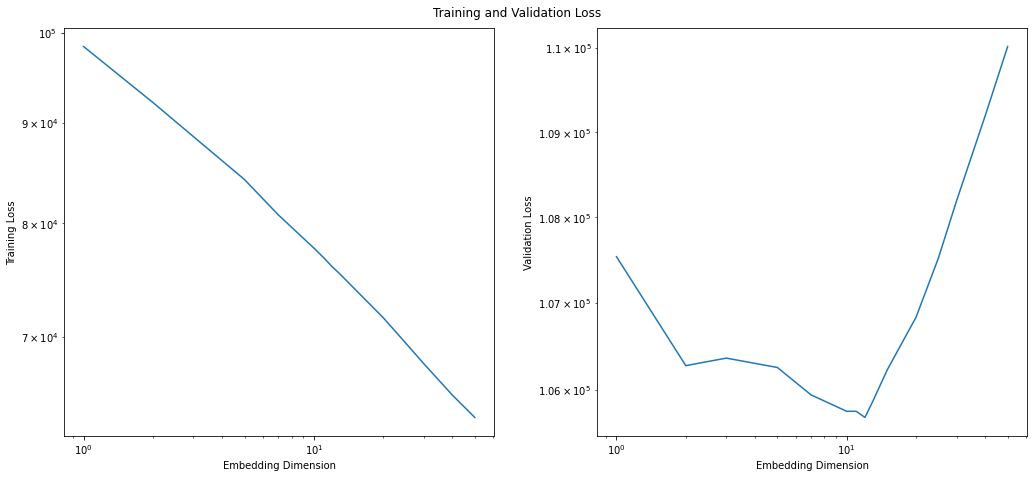

In [ ]:
fig, (ax1, ax2) = pylab.subplots(1, 2,figsize=(15,7))
fig.suptitle('Training and Validation Loss')
ax1.loglog(embedding_dims, final_train_losses)
ax2.loglog(embedding_dims, final_val_losses)
ax1.set(xlabel="Embedding Dimension", ylabel="Training Loss")
ax2.set(xlabel="Embedding Dimension", ylabel="Validation Loss")
fig.tight_layout(pad=3.0)
fig.show()


As can be observed from plot's above, while the training loss decreases as the size of the embedding vector increases, the same isn't necessarily true for the validation loss. The dimensionality $d$ that results in the best validation performance is 12. 

Having a larger $d$ does not always lead to a reduction in the loss since the model could (and did in this case once $d$ exceeded 12) overfit to the training samples, resulting in the model not generalizing to new words in the validation set.


# Part 2: Network Architecture

We now train a neural language model as in Bengio et al. [2003]. It receives as input 3 consecutive words, and its aim is to predict a
distribution over the next word (the target word). We train the model using the cross-entropy
criterion, which is equivalent to maximizing the probability it assigns to the targets in the training
set. Hopefully it will also learn to make sensible predictions for sequences it hasn’t seen before. The diagram below outlines our model architecture.

<br>

![Fig1](https://drive.google.com/uc?id=1ppqxOWgKnyyjaZ7X4F6AUHrF13IO7JVk)

<br>

The network consists of an input layer, embedding layer, hidden layer and output layer. The
input consists of a sequence of 3 consecutive words, given as integer valued indices (i.e., the 250
words in our dictionary are arbitrarily assigned integer values from 0 to 249).The embedding
layer maps each word to its corresponding vector representation. This layer has 3 × D units, where
D is the embedding dimension, and it essentially functions as a lookup table. We share the *same*
lookup table between all 3 positions, *i.e.* we don’t learn a separate word embedding for each context
position. The embedding layer is connected to the hidden layer, which uses a logistic nonlinearity.
The hidden layer in turn is connected to the output layer. The output layer is a softmax over the
250 words.



# Part 3: Training the Model

In this section we implement a method for computing the gradient using back-propogation.

There are three classes defined in this section: `Params`, `Activations`, and `Model`. `Params` represents the model's trainable parameters and `Activations` represents activations of the units in the network.

In [ ]:
class Params(object):
    """A class representing the trainable parameters of the model. This class has five fields:
    
           word_embedding_weights, a matrix of size N_V x D, where N_V is the number of words in the vocabulary
                   and D is the embedding dimension.
           embed_to_hid_weights, a matrix of size N_H x 3D, where N_H is the number of hidden units. The first D
                   columns represent connections from the embedding of the first context word, the next D columns
                   for the second context word, and so on.
           hid_bias, a vector of length N_H
           hid_to_output_weights, a matrix of size N_V x N_H
           output_bias, a vector of length N_V"""

    def __init__(self, word_embedding_weights, embed_to_hid_weights, hid_to_output_weights,
                 hid_bias, output_bias):
        self.word_embedding_weights = word_embedding_weights
        self.embed_to_hid_weights = embed_to_hid_weights
        self.hid_to_output_weights = hid_to_output_weights
        self.hid_bias = hid_bias
        self.output_bias = output_bias

    def copy(self):
        return self.__class__(self.word_embedding_weights.copy(), self.embed_to_hid_weights.copy(),
                              self.hid_to_output_weights.copy(), self.hid_bias.copy(), self.output_bias.copy())

    @classmethod
    def zeros(cls, vocab_size, context_len, embedding_dim, num_hid):
        """A constructor which initializes all weights and biases to 0."""
        word_embedding_weights = np.zeros((vocab_size, embedding_dim))
        embed_to_hid_weights = np.zeros((num_hid, context_len * embedding_dim))
        hid_to_output_weights = np.zeros((vocab_size, num_hid))
        hid_bias = np.zeros(num_hid)
        output_bias = np.zeros(vocab_size)
        return cls(word_embedding_weights, embed_to_hid_weights, hid_to_output_weights,
                   hid_bias, output_bias)

    @classmethod
    def random_init(cls, init_wt, vocab_size, context_len, embedding_dim, num_hid):
        """A constructor which initializes weights to small random values and biases to 0."""
        word_embedding_weights = np.random.normal(0., init_wt, size=(vocab_size, embedding_dim))
        embed_to_hid_weights = np.random.normal(0., init_wt, size=(num_hid, context_len * embedding_dim))
        hid_to_output_weights = np.random.normal(0., init_wt, size=(vocab_size, num_hid))
        hid_bias = np.zeros(num_hid)
        output_bias = np.zeros(vocab_size)
        return cls(word_embedding_weights, embed_to_hid_weights, hid_to_output_weights,
                   hid_bias, output_bias)

    def __mul__(self, a):
        return self.__class__(a * self.word_embedding_weights,
                              a * self.embed_to_hid_weights,
                              a * self.hid_to_output_weights,
                              a * self.hid_bias,
                              a * self.output_bias)

    def __rmul__(self, a):
        return self * a

    def __add__(self, other):
        return self.__class__(self.word_embedding_weights + other.word_embedding_weights,
                              self.embed_to_hid_weights + other.embed_to_hid_weights,
                              self.hid_to_output_weights + other.hid_to_output_weights,
                              self.hid_bias + other.hid_bias,
                              self.output_bias + other.output_bias)

    def __sub__(self, other):
        return self + -1. * other

In [ ]:
class Activations(object):
    """A class representing the activations of the units in the network. This class has three fields:

        embedding_layer, a matrix of B x 3D matrix (where B is the batch size and D is the embedding dimension),
                representing the activations for the embedding layer on all the cases in a batch. The first D
                columns represent the embeddings for the first context word, and so on.
        hidden_layer, a B x N_H matrix representing the hidden layer activations for a batch
        output_layer, a B x N_V matrix representing the output layer activations for a batch"""

    def __init__(self, embedding_layer, hidden_layer, output_layer):
        self.embedding_layer = embedding_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer

def get_batches(inputs, targets, batch_size, shuffle=True):
    """Divide a dataset (usually the training set) into mini-batches of a given size. This is a
    'generator', i.e. something you can use in a for loop. You don't need to understand how it
    works to do the assignment."""

    if inputs.shape[0] % batch_size != 0:
        raise RuntimeError('The number of data points must be a multiple of the batch size.')
    num_batches = inputs.shape[0] // batch_size

    if shuffle:
        idxs = np.random.permutation(inputs.shape[0])
        inputs = inputs[idxs, :]
        targets = targets[idxs]

    for m in range(num_batches):
        yield inputs[m * batch_size:(m + 1) * batch_size, :], \
              targets[m * batch_size:(m + 1) * batch_size]

We now shift our attention to the `Model` class which contains the following key methods:

*   `compute_activations` computes the activations of all units on a given input batch
*   `compute_loss` computes the total cross-entropy loss on a mini-batch
*   `evaluate` computes the average cross-entropy loss for a given set of inputs and targets

*   `compute_loss_derivative` computes the derivative of the loss function, $C$, with respect to the output layer inputs. Note that the output layer is the softmax computation defined as $y_{i}=\frac{e^{z_{i}}}{\sum_{j} e^{z_{j}}}$ and so this method outputs a $B × N_V$ matrix whose entries correspond to the partial derivatives $\partial C / \partial z_{i}$
*   `back_propagate` is the function which computes the gradient of the loss with respect to model parameters using backpropagation.
It uses the derivatives computed by *compute_loss_derivative*





In [ ]:
class Model(object):
  
    def __init__(self, params, vocab):
        self.params = params
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.embedding_dim = self.params.word_embedding_weights.shape[1]
        self.embedding_layer_dim = self.params.embed_to_hid_weights.shape[1]
        self.context_len = self.embedding_layer_dim // self.embedding_dim
        self.num_hid = self.params.embed_to_hid_weights.shape[0]

    def copy(self):
        return self.__class__(self.params.copy(), self.vocab[:])

    @classmethod
    def random_init(cls, init_wt, vocab, context_len, embedding_dim, num_hid):
        """Constructor which randomly initializes the weights to Gaussians with standard deviation init_wt
        and initializes the biases to all zeros."""
        params = Params.random_init(init_wt, len(vocab), context_len, embedding_dim, num_hid)
        return Model(params, vocab)

    def indicator_matrix(self, targets):
        """Construct a matrix where the kth entry of row i is 1 if the target for example
        i is k, and all other entries are 0."""
        batch_size = targets.size
        expanded_targets = np.zeros((batch_size, len(self.vocab)))
        expanded_targets[np.arange(batch_size), targets] = 1.
        return expanded_targets

    def compute_loss_derivative(self, output_activations, expanded_target_batch):
        """Compute the derivative of the cross-entropy loss function with respect to the inputs
        to the output units. In particular, the output layer computes the softmax

            y_i = e^{z_i} / \sum_j e^{z_j}.

        This function should return a batch_size x vocab_size matrix, where the (i, j) entry
        is dC / dz_j computed for the ith training case, where C is the loss function

            C = -sum(t_i log y_i).

        The arguments are as follows:

            output_activations - the activations of the output layer, i.e. the y_i's.
            expanded_target_batch - each row is the indicator vector for a target word,
                i.e. the (i, j) entry is 1 if the i'th word is j, and 0 otherwise."""

        return -expanded_target_batch + output_activations
     
    def compute_loss(self, output_activations, expanded_target_batch):
        """Compute the total loss over a mini-batch. expanded_target_batch is the matrix obtained
        by calling indicator_matrix on the targets for the batch."""

        return -np.sum(expanded_target_batch * np.log(output_activations + TINY))

    def compute_activations(self, inputs):
        """Compute the activations on a batch given the inputs. Returns an Activations instance.
        You should try to read and understand this function, since this will give you clues for
        how to implement back_propagate."""

        batch_size = inputs.shape[0]
        if inputs.shape[1] != self.context_len:
            raise RuntimeError('Dimension of the input vectors should be {}, but is instead {}'.format(
                self.context_len, inputs.shape[1]))
      
        # Embedding layer
        # Look up the input word indies in the word_embedding_weights matrix
        embedding_layer_state = np.zeros((batch_size, self.embedding_layer_dim))
        for i in range(self.context_len):
            embedding_layer_state[:, i * self.embedding_dim:(i + 1) * self.embedding_dim] = \
                self.params.word_embedding_weights[inputs[:, i], :]

        # Hidden layer
        inputs_to_hid = np.dot(embedding_layer_state, self.params.embed_to_hid_weights.T) + \
                        self.params.hid_bias
                        
        # Apply logistic activation function
        hidden_layer_state = 1. / (1. + np.exp(-inputs_to_hid))

        # Output layer
        inputs_to_softmax = np.dot(hidden_layer_state, self.params.hid_to_output_weights.T) + \
                            self.params.output_bias

        # Subtract maximum.
        # Adding or subtracting the same constant from each input to a
        # softmax unit does not affect the outputs. So subtract the maximum to
        # make all inputs <= 0. This prevents overflows when computing their exponents.
        inputs_to_softmax -= inputs_to_softmax.max(1).reshape((-1, 1))

        output_layer_state = np.exp(inputs_to_softmax)
        output_layer_state /= output_layer_state.sum(1).reshape((-1, 1))

        return Activations(embedding_layer_state, hidden_layer_state, output_layer_state)

    def back_propagate(self, input_batch, activations, loss_derivative):
        """Compute the gradient of the loss function with respect to the trainable parameters
        of the model. The arguments are as follows:

             input_batch - the indices of the context words
             activations - an Activations class representing the output of Model.compute_activations
             loss_derivative - the matrix of derivatives computed by compute_loss_derivative
             
        Part of this function is already completed, but you need to fill in the derivative
        computations for hid_to_output_weights_grad, output_bias_grad, embed_to_hid_weights_grad,
        and hid_bias_grad. See the documentation for the Params class for a description of what
        these matrices represent."""

        # The matrix with values dC / dz_j, where dz_j is the input to the jth hidden unit,
        # i.e. y_j = 1 / (1 + e^{-z_j})
        hid_deriv = np.dot(loss_derivative, self.params.hid_to_output_weights) \
                    * activations.hidden_layer * (1. - activations.hidden_layer)

      
        input_batch.shape
        hid_to_output_weights_grad = loss_derivative.T @ activations.hidden_layer
        output_bias_grad = loss_derivative.T @ np.ones(input_batch.shape[0])
        
        embed_to_hid_weights_grad = hid_deriv.T @ activations.embedding_layer
        hid_bias_grad = hid_deriv.T @ np.ones(input_batch.shape[0])

        # The matrix of derivatives for the embedding layer
        embed_deriv = np.dot(hid_deriv, self.params.embed_to_hid_weights)

        # Embedding layer
        word_embedding_weights_grad = np.zeros((self.vocab_size, self.embedding_dim))
        for w in range(self.context_len):
            word_embedding_weights_grad += np.dot(self.indicator_matrix(input_batch[:, w]).T,
                                                  embed_deriv[:, w * self.embedding_dim:(w + 1) * self.embedding_dim])

        return Params(word_embedding_weights_grad, embed_to_hid_weights_grad, hid_to_output_weights_grad,
                      hid_bias_grad, output_bias_grad)

    def evaluate(self, inputs, targets, batch_size=100):
        """Compute the average cross-entropy over a dataset.

            inputs: matrix of shape D x N
            targets: one-dimensional matrix of length N"""

        ndata = inputs.shape[0]

        total = 0.
        for input_batch, target_batch in get_batches(inputs, targets, batch_size):
            activations = self.compute_activations(input_batch)
            expanded_target_batch = self.indicator_matrix(target_batch)
            cross_entropy = -np.sum(expanded_target_batch * np.log(activations.output_layer + TINY))
            total += cross_entropy

        return total / float(ndata)

    def display_nearest_words(self, word, k=10):
        """List the k words nearest to a given word, along with their distances."""

        if word not in self.vocab:
            print('Word "{}" not in vocabulary.'.format(word))
            return

        # Compute distance to every other word.
        idx = self.vocab.index(word)
        word_rep = self.params.word_embedding_weights[idx, :]
        diff = self.params.word_embedding_weights - word_rep.reshape((1, -1))
        distance = np.sqrt(np.sum(diff ** 2, axis=1))

        # Sort by distance.
        order = np.argsort(distance)
        order = order[1:1 + k]  # The nearest word is the query word itself, skip that.
        for i in order:
            print('{}: {}'.format(self.vocab[i], distance[i]))

    def predict_next_word(self, word1, word2, word3, k=10):
        """List the top k predictions for the next word along with their probabilities.
        Inputs:
            word1: The first word as a string.
            word2: The second word as a string.
            word3: The third word as a string.
            k: The k most probable predictions are shown.
        Example usage:
            model.predict_next_word('john', 'might', 'be', 3)
            model.predict_next_word('life', 'in', 'new', 3)"""

        if word1 not in self.vocab:
            raise RuntimeError('Word "{}" not in vocabulary.'.format(word1))
        if word2 not in self.vocab:
            raise RuntimeError('Word "{}" not in vocabulary.'.format(word2))
        if word3 not in self.vocab:
            raise RuntimeError('Word "{}" not in vocabulary.'.format(word3))

        idx1, idx2, idx3 = self.vocab.index(word1), self.vocab.index(word2), self.vocab.index(word3)
        input = np.array([idx1, idx2, idx3]).reshape((1, -1))
        activations = self.compute_activations(input)
        prob = activations.output_layer.ravel()
        idxs = np.argsort(prob)[::-1]  # sort descending
        for i in idxs[:k]:
            print('{} {} {} {} Prob: {:1.5f}'.format(word1, word2, word3, self.vocab[i], prob[i]))

    def word_distance(self, word1, word2):
        """Compute the distance between the vector representations of two words."""

        if word1 not in self.vocab:
            raise RuntimeError('Word "{}" not in vocabulary.'.format(word1))
        if word2 not in self.vocab:
            raise RuntimeError('Word "{}" not in vocabulary.'.format(word2))

        idx1, idx2 = self.vocab.index(word1), self.vocab.index(word2)
        word_rep1 = self.params.word_embedding_weights[idx1, :]
        word_rep2 = self.params.word_embedding_weights[idx2, :]
        diff = word_rep1 - word_rep2
        return np.sqrt(np.sum(diff ** 2))

Now that we've implemented our model, we're ready to implement the training of the model.
The function `train` implements the main training procedure.
It takes two arguments:


*   *embedding_dim*: The number of dimensions in the distributed representation
*   *num_hid*: The number of hidden units


As the model trains, the script prints out some numbers that tell you how well the training is going.
It shows:


*   The cross entropy on the last 100 mini-batches of the training set. This is shown after every 100 mini-batches
*   The cross entropy on the entire validation set every 1000 mini-batches of training

At the end of training, this function shows the cross entropies on the training, validation and test sets.
It will return a *Model* instance.

In [ ]:
_train_inputs = None
_train_targets = None
_vocab = None

DEFAULT_TRAINING_CONFIG = {'batch_size': 100,  # the size of a mini-batch
                           'learning_rate': 0.1,  # the learning rate
                           'momentum': 0.9,  # the decay parameter for the momentum vector
                           'epochs': 50,  # the maximum number of epochs to run
                           'init_wt': 0.01,  # the standard deviation of the initial random weights
                           'context_len': 3,  # the number of context words used
                           'show_training_CE_after': 100,  # measure training error after this many mini-batches
                           'show_validation_CE_after': 1000,  # measure validation error after this many mini-batches
                           }


def find_occurrences(word1, word2, word3):
    """Lists all the words that followed a given tri-gram in the training set and the number of
    times each one followed it."""

    # cache the data so we don't keep reloading
    global _train_inputs, _train_targets, _vocab
    if _train_inputs is None:
        data_obj = pickle.load(open('data.pk', 'rb'))
        _vocab = data_obj['vocab']
        _train_inputs, _train_targets = data_obj['train_inputs'], data_obj['train_targets']

    if word1 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word1))
    if word2 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word2))
    if word3 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word3))

    idx1, idx2, idx3 = _vocab.index(word1), _vocab.index(word2), _vocab.index(word3)
    idxs = np.array([idx1, idx2, idx3])

    matches = np.all(_train_inputs == idxs.reshape((1, -1)), 1)

    if np.any(matches):
        counts = collections.defaultdict(int)
        for m in np.where(matches)[0]:
            counts[_vocab[_train_targets[m]]] += 1

        word_counts = sorted(list(counts.items()), key=lambda t: t[1], reverse=True)
        print('The tri-gram "{} {} {}" was followed by the following words in the training set:'.format(
            word1, word2, word3))
        for word, count in word_counts:
            if count > 1:
                print('    {} ({} times)'.format(word, count))
            else:
                print('    {} (1 time)'.format(word))
    else:
        print('The tri-gram "{} {} {}" did not occur in the training set.'.format(word1, word2, word3))


def train(embedding_dim, num_hid, config=DEFAULT_TRAINING_CONFIG):
    """This is the main training routine for the language model. It takes two parameters:

        embedding_dim, the dimension of the embeddilanguage_model.pyng space
        num_hid, the number of hidden units."""

    # Load the data
    data_obj = pickle.load(open('data.pk', 'rb'))
    vocab = data_obj['vocab']
    train_inputs, train_targets = data_obj['train_inputs'], data_obj['train_targets']
    valid_inputs, valid_targets = data_obj['valid_inputs'], data_obj['valid_targets']
    test_inputs, test_targets = data_obj['test_inputs'], data_obj['test_targets']

    # Randomly initialize the trainable parameters
    model = Model.random_init(config['init_wt'], vocab, config['context_len'], embedding_dim, num_hid)

    # Variables used for early stopping
    best_valid_CE = np.infty
    end_training = False

    # Initialize the momentum vector to all zeros
    delta = Params.zeros(len(vocab), config['context_len'], embedding_dim, num_hid)

    this_chunk_CE = 0.
    batch_count = 0
    for epoch in range(1, config['epochs'] + 1):
        if end_training:
            break

        print()
        print('Epoch', epoch)

        for m, (input_batch, target_batch) in enumerate(get_batches(train_inputs, train_targets,
                                                                    config['batch_size'])):
            batch_count += 1

            # Forward propagate
            activations = model.compute_activations(input_batch)

            # Compute loss derivative
            expanded_target_batch = model.indicator_matrix(target_batch)
            loss_derivative = model.compute_loss_derivative(activations.output_layer, expanded_target_batch)
            loss_derivative /= config['batch_size']

            # Measure loss function
            cross_entropy = model.compute_loss(activations.output_layer, expanded_target_batch) / config['batch_size']
            this_chunk_CE += cross_entropy
            if batch_count % config['show_training_CE_after'] == 0:
                print('Batch {} Train CE {:1.3f}'.format(
                    batch_count, this_chunk_CE / config['show_training_CE_after']))
                this_chunk_CE = 0.

            # Backpropagate
            loss_gradient = model.back_propagate(input_batch, activations, loss_derivative)

            # Update the momentum vector and model parameters
            delta = config['momentum'] * delta + loss_gradient
            model.params -= config['learning_rate'] * delta

            # Validate
            if batch_count % config['show_validation_CE_after'] == 0:
                print('Running validation...')
                cross_entropy = model.evaluate(valid_inputs, valid_targets)
                print('Validation cross-entropy: {:1.3f}'.format(cross_entropy))

                if cross_entropy > best_valid_CE:
                    print('Validation error increasing!  Training stopped.')
                    end_training = True
                    break

                best_valid_CE = cross_entropy

    print()
    train_CE = model.evaluate(train_inputs, train_targets)
    print('Final training cross-entropy: {:1.3f}'.format(train_CE))
    valid_CE = model.evaluate(valid_inputs, valid_targets)
    print('Final validation cross-entropy: {:1.3f}'.format(valid_CE))
    test_CE = model.evaluate(test_inputs, test_targets)
    print('Final test cross-entropy: {:1.3f}'.format(test_CE))

    return model

We now run the training:


In [ ]:
embedding_dim = 16
num_hid = 128
trained_model = train(embedding_dim, num_hid)

# Part 4: Analysis
In this part, we analyze the representation learned by the network. We first train a
model with a 16-dimensional embedding and 128 hidden units, as described in the previous section.

Here, we use the trained model and the following methods of the `Model` class to analyze:



*   `display_nearest_words` lists the words whose embedding vectors are nearest to the given
word
*   `word_distance` computes the distance between the embeddings of two words
*   `predict_next_word` shows the possible next words the model considers most likely, along
with their probabilities
*    `tsne_plot_representation` creates a 2-dimensional embedding of the distributed representation space using
an algorithm called t-SNE. Nearby points in this 2-D space are meant to correspond to
nearby points in the 16-D space.

In [ ]:
import numpy as Math

def Hbeta(D=Math.array([]), beta=1.0):
    """Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""

    # Compute P-row and corresponding perplexity
    P = Math.exp(-D.copy() * beta);
    sumP = sum(P);
    H = Math.log(sumP) + beta * Math.sum(D * P) / sumP;
    P = P / sumP;
    return H, P;


def x2p(X=Math.array([]), tol=1e-5, perplexity=30.0):
    """Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape;
    sum_X = Math.sum(Math.square(X), 1);
    D = Math.add(Math.add(-2 * Math.dot(X, X.T), sum_X).T, sum_X);
    P = Math.zeros((n, n));
    beta = Math.ones((n, 1));
    logU = Math.log(perplexity);

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point ", i, " of ", n, "...")

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -Math.inf;
        betamax = Math.inf;
        Di = D[i, Math.concatenate((Math.r_[0:i], Math.r_[i + 1:n]))];
        (H, thisP) = Hbeta(Di, beta[i]);

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU;
        tries = 0;
        while Math.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i];
                if betamax == Math.inf or betamax == -Math.inf:
                    beta[i] = beta[i] * 2;
                else:
                    beta[i] = (beta[i] + betamax) / 2;
            else:
                betamax = beta[i];
                if betamin == Math.inf or betamin == -Math.inf:
                    beta[i] = beta[i] / 2;
                else:
                    beta[i] = (beta[i] + betamin) / 2;

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i]);
            Hdiff = H - logU;
            tries = tries + 1;

        # Set the final row of P
        P[i, Math.concatenate((Math.r_[0:i], Math.r_[i + 1:n]))] = thisP;

    # Return final P-matrix
    print("Mean value of sigma: ", Math.mean(Math.sqrt(1 / beta)))
    return P;


def pca(X=Math.array([]), no_dims=50):
    """Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape;
    X = X - Math.tile(Math.mean(X, 0), (n, 1));
    (l, M) = Math.linalg.eig(Math.dot(X.T, X));
    Y = Math.dot(X, M[:, 0:no_dims]);
    return Y;


def tsne(X=Math.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """Runs t-SNE on the dataset in the NxD array X to reduce its dimensionality to no_dims dimensions.
    The syntaxis of the function is Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array."""

    # Check inputs
    if X.dtype != "float64":
        print("Error: array X should have type float64.");
        return -1;
    # if no_dims.__class__ != "<type 'int'>":			# doesn't work yet!
    #	print("Error: number of dimensions should be an integer.");
    #	return -1;

    # Initialize variables
    X = pca(X, initial_dims);
    (n, d) = X.shape;
    max_iter = 1000;
    initial_momentum = 0.5;
    final_momentum = 0.8;
    eta = 500;
    min_gain = 0.01;
    Y = Math.random.randn(n, no_dims);
    dY = Math.zeros((n, no_dims));
    iY = Math.zeros((n, no_dims));
    gains = Math.ones((n, no_dims));

    # Compute P-values
    P = x2p(X, 1e-5, perplexity);
    P = P + Math.transpose(P);
    P = P / Math.sum(P);
    P = P * 4;  # early exaggeration
    P = Math.maximum(P, 1e-12);

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = Math.sum(Math.square(Y), 1);
        num = 1 / (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y));
        num[range(n), range(n)] = 0;
        Q = num / Math.sum(num);
        Q = Math.maximum(Q, 1e-12);

        # Compute gradient
        PQ = P - Q;
        for i in range(n):
            dY[i, :] = Math.sum(Math.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0);

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0));
        gains[gains < min_gain] = min_gain;
        iY = momentum * iY - eta * (gains * dY);
        Y = Y + iY;
        Y = Y - Math.tile(Math.mean(Y, 0), (n, 1));

        # Compute current value of cost function
        #if (iter + 1) % 10 == 0:
        #   C = Math.sum(P * Math.log(P / Q));
        #    print("Iteration ", (iter + 1), ": error is ", C)

        # Stop lying about P-values
        if iter == 100:
            P = P / 4;

    # Return solution
    return Y;

def tsne_plot_representation(model):
    """Plot a 2-D visualization of the learned representations using t-SNE."""
    print(model.params.word_embedding_weights.shape)
    mapped_X = tsne(model.params.word_embedding_weights)
    pylab.figure(figsize=(15,7))
    for i, w in enumerate(model.vocab):
        pylab.text(mapped_X[i, 0], mapped_X[i, 1], w)
    pylab.xlim(mapped_X[:, 0].min(), mapped_X[:, 0].max())
    pylab.ylim(mapped_X[:, 1].min(), mapped_X[:, 1].max())
    pylab.show()

def tsne_plot_GLoVE_representation(W_final, b_final):
    """Plot a 2-D visualization of the learned representations using t-SNE."""
    mapped_X = tsne(W_final)
    pylab.figure(figsize=(15,7))
    data_obj = pickle.load(open('data.pk', 'rb'))
    for i, w in enumerate(data_obj['vocab']):
        pylab.text(mapped_X[i, 0], mapped_X[i, 1], w)
    pylab.xlim(mapped_X[:, 0].min(), mapped_X[:, 0].max())
    pylab.ylim(mapped_X[:, 1].min(), mapped_X[:, 1].max())
    pylab.show()

def plot_2d_GLoVE_representation(W_final, b_final):
    """Plot a 2-D visualization of the learned representations."""
    mapped_X = W_final
    pylab.figure(figsize=(15,7))
    data_obj = pickle.load(open('data.pk', 'rb'))
    for i, w in enumerate(data_obj['vocab']):
        pylab.text(mapped_X[i, 0], mapped_X[i, 1], w)
    pylab.xlim(mapped_X[:, 0].min(), mapped_X[:, 0].max())
    pylab.ylim(mapped_X[:, 1].min(), mapped_X[:, 1].max())
    pylab.show()

Using these methods, please answer the following questions, each of which is worth 1 point.



1.   Pick three words from the vocabulary that go well together (for example, ‘*government of united*’,
‘*city of new*’, ‘*life in the*’, ‘*he is the*’ etc.).
Use the model to predict the next word.
Does the model give sensible predictions?
Try to find an example where it makes a plausible prediction even though the 4-gram wasn’t present in the dataset (*raw_sentences.txt*).
To help you out, the function *find_occurrences* lists the words that appear after a given 3-gram in the training set.
2.   Plot the 2-dimensional visualization using the method *tsne_plot_representation*.
Look at the plot and find a few clusters of related words.
What do the words in each cluster have in common?
Plot the 2-dimensional visualization using the method *tsne_plot_GLoVE_representation* for a 256 dimensional embedding.
How do the t-SNE embeddings for both models compare?
Plot the 2-dimensional visualization using the method *plot_2d_GLoVE_representation*.
How does this compare to the t-SNE embeddings?
(You don’t need to include the plots with your submission.)

3.   Are the words ‘*new*’ and ‘*york*’ close together in the learned representation?
Why or why not?
4.   Which pair of words is closer together in the learned representation: (‘*government*’, ‘*political*’), or (‘*government*’, ‘*university*’)?
Why do you think this is?



## 4.1. Predicting the Next Word for a New Trigram

For our first experiment, we select a sequence of 3 words (trigram) that did not occur in our training set, which we verify using `find_occurences` and then see what our model thinks is the next most likely word using `predict_next_word`

In [ ]:
w1 = "the"
w2 = "war"
w3 = "should"

In [ ]:
find_occurrences(w1,w2,w3)

The tri-gram "the war should" did not occur in the training set.


In [ ]:
trained_model.predict_next_word(w1,w2,w3)

the war should be Prob: 0.38753
the war should nt Prob: 0.21410
the war should not Prob: 0.10686
the war should have Prob: 0.05168
the war should . Prob: 0.02898
the war should never Prob: 0.02791
the war should do Prob: 0.01883
the war should come Prob: 0.01344
the war should the Prob: 0.01023
the war should , Prob: 0.00985


Interesting! Given the sequence, "the war should", our model predicts the most likely word to follow is "be" with a nearly 40% liklihood. The second most likely 4th word according to our model is "nt", as in, "the war should'nt".

The real question now is, what should the war be or not be, oh all seeing model (and which war for that matter!)?

## 4.2. Visual Representation of Word Embeddings

We now plot the 2-dimensional visualization using the method `tsne_plot_representation`. We observe the plot and find a few clusters of related words and identify what they have in common. We also plot the 2-dimensional visualization using the method `tsne_plot_GLoVE_representation` for a 256 dimensional embedding and compare t-SNE embeddings for both models. Finally, we plot the 2-dimensional visualization using the method `plot_2d_GLoVE_representation` and do a similar comparison.



(250, 16)
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  250 ...
Mean value of sigma:  1.2073250352560272


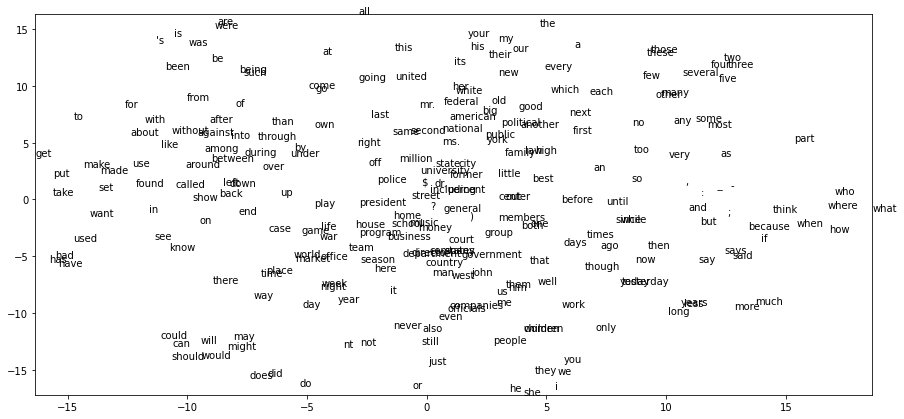

In [ ]:
tsne_plot_representation(trained_model)

Very interesting results indeed! We can see that the model clearly learned some valid relationships between some words in its 250 word vocabulary. For example, the cluster in the top right corner contains the words "two", "three", "four", "five", and interestingly enough, "several". This cluster contains both a set of numbers. The word "several" being included in this cluster seems to suggest that the model associates this cluster with concept of *counting* or *enumerating*. Another interesting cluster near the top border of the plot to the left contains "are", "were", "is", "was", and "be". The model has learned that these words, inspite of having very different forms", are generally used in the same context and so the model has deemed them similar.

There are many more very interesting clusters such as "who", "where", "what", "how", and "when", or "says" and "said". Can you find any more?

We now compare with the visual representation of the GLoVE model's learned word similarities...

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  250 ...
Mean value of sigma:  0.7386214998123092


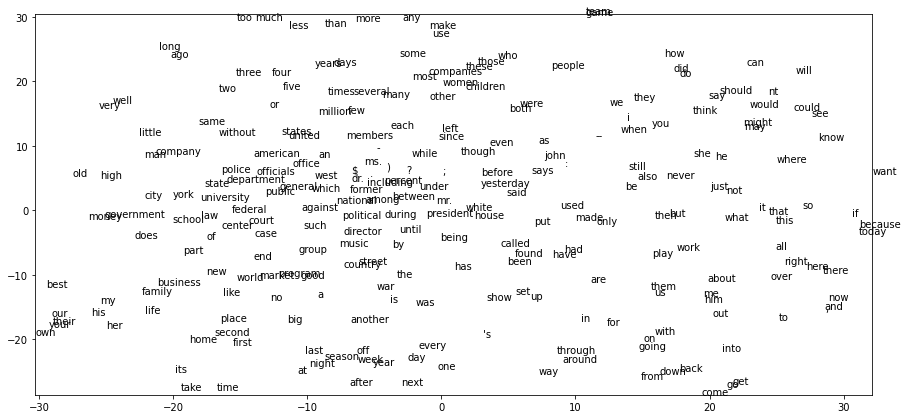

In [ ]:
tsne_plot_GLoVE_representation(W_final, b_final)

Another fascinating result. We observe that this model produces a cluster for the words for numbers 2 to 5, notably however, "several" isn't in this cluster. Another interesting observation is that this model seems to have clusters of words that *often go together* as opposed to *different words that are similar in meaning*. For example, in the GLoVE representation, a cluster contains "every" and "day". Another contains "long" and "ago". And yet another contains "very" and "well". These words are not similar in the sense that they mean the same thing, but are rather often used together.

And finally, we compare the results with a model that has word embedding dimension, $d$, of 2...

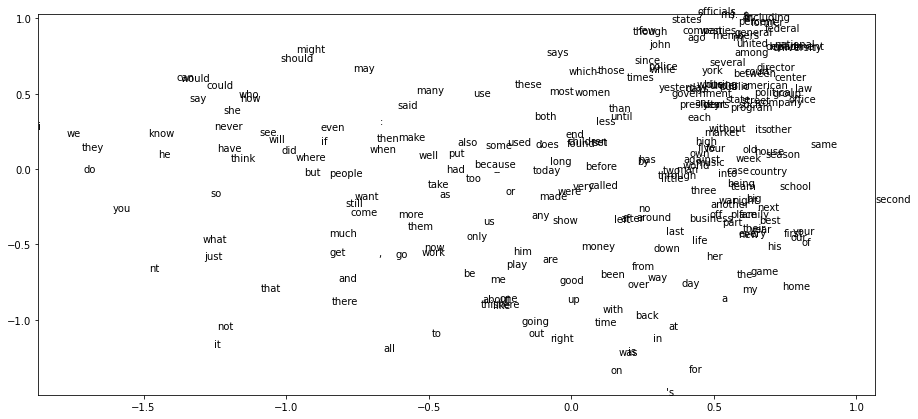

In [ ]:
plot_2d_GLoVE_representation(W_final_2d, b_final_2d)

Suprisingly, even with a very small embedding dimensionality, we still observe some valid relationships between words in the vocabulary. For example, "should" and "might" appear together and same with "would" and "could" or "who" and "how", or even "we" and "they". Another observation is that there is very large cluster of words towards the right, and more so in the top right corner. This suggests that the model is having a harder time distinguishing between these words, which consequently suggests (as we would expect) that a 2-dimensional embedding rsults in the model underfitting the data. Said differently, a 2-dimensional embedding is not enough for the model represent the differences in meanings of words.

## 4.3. Word Similarity
For a final experiment, we explore how similar our trained model thinks any two given words are. This enables us to ask questions like, "*How similar is Word 1 to Word 2?*", or "*Is Word 1 closer to Word 2 or Word 3?*" We illustrate both examples below:

In [ ]:
trained_model.word_distance("new","york")

3.4406137735580433

In [ ]:
print("similarity between 'government' and 'political' : {}".format(trained_model.word_distance("government","political")))
print("similarity between 'government' and 'university' : {}".format(trained_model.word_distance("government","university")))

similarity between 'government' and 'political' : 1.2808505981043472
similarity between 'government' and 'university' : 1.1354211512226058


# References

* Jimmy Ba. Learning Distributed Word Representations
. *University of Toronto, CSC413*, 2020.

* Richard Socher Jeffrey Pennington and Christopher D Manning. Glove: Global vectors for word
representation. Citeseer.

* Yoshua Bengio, R´ejean Ducharme, Pascal Vincent, and Christian Jauvin. A neural probabilistic
language model. *Journal of machine learning research*, 3(Feb):1137–1155, 2003.

* Laurens van der Maaten and Geoffrey Hinton. Visualizing data using t-sne. *Journal of machine
learning research*, 9(Nov):2579–2605, 2008.

